## Subtask 2 - Polarization type classification

Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

## Imports

In [1]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [2]:
import random
import numpy as np
import torch

SEED = 42

# Python
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch (CPU)
torch.manual_seed(SEED)

# PyTorch (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you have multiple GPUs

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

## Data Import

In [4]:
# Load the training and validation data for subtask 1

train = pd.read_csv('subtask2/train/eng.csv')
# train_plus = pd.read_csv('english_data.csv')
train_plus = pd.read_csv('eng_BT_full.csv')
# dev = pd.read_csv('dev/swa.csv')
# val = pd.read_csv('train/swa.csv')
train.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0


In [5]:
train_plus.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other,back_translated
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0,defends imperialism in the dnd cat
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0,I'm Rachel Maddie from msnbc.
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0,".senate.gov Theres 3 groups there Republicans,..."
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0,"""Continuing investment in ABC is essential to ..."
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0,I have conservative values and that makes me o...


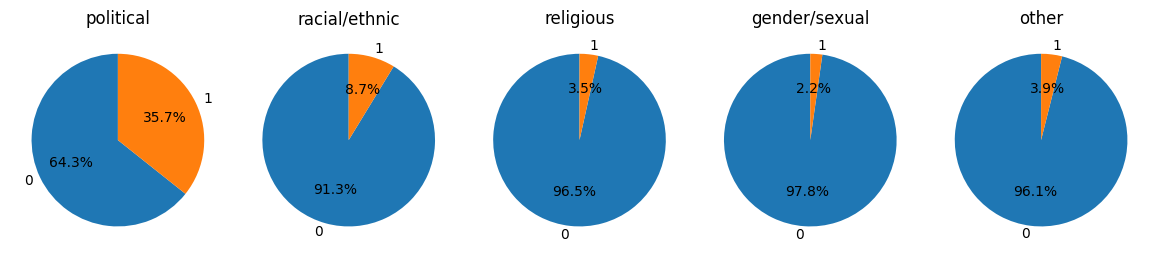

In [6]:
import matplotlib.pyplot as plt

# Only relevant label
labels = train.columns[2:]
n = len(labels)

# A4 landscape size (inches)
fig, axes = plt.subplots(1, n, figsize=(11.69, 2.8))

# If only one label, axes is not iterable
if n == 1:
    axes = [axes]

for idx, label in enumerate(labels):
    counts = train[label].value_counts().sort_index()
    
    axes[idx].pie(
        counts,
        labels=["0", "1"],
        autopct="%1.1f%%",
        startangle=90
    )
    axes[idx].set_title(label)

plt.tight_layout()
plt.savefig("repartition.pdf")
plt.show()

# Dataset
-  Create a pytorch class for handling data
-  Wrapping the raw texts and labels into a format that Huggingface’s Trainer can use for training and evaluation

In [7]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

Now, we'll tokenize the text data and create the datasets using `bert-base-uncased` as the tokenizer.

## Base-line from here

In [8]:
# Load the tokenizer
MODEL_NAME = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## Data processing

In [9]:
# Add the labels to the translated
train_plus = train_plus.drop(columns=["text"])
train_plus['text'] = train_plus['back_translated']
# train_plus[['political','racial/ethnic','religious','gender/sexual','other']] = train[['political','racial/ethnic','religious','gender/sexual','other']].values
# train_plus = pd.concat([train_plus, train[['political','racial/ethnic','religious','gender/sexual','other']]], axis=1)

# Sample some from the translation
sample_size = 1000
back_tranlated_sampled = train_plus.sample(n=1000)

train_combined = pd.concat([train, back_tranlated_sampled], axis=0)
val_df = back_tranlated_sampled.sample(n=300, random_state=42)


# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(
    train_combined['text'].tolist(),
    train_combined[['political','racial/ethnic','religious','gender/sexual','other']].values.tolist(),
    tokenizer
)
val = PolarizationDataset(
    val_df['text'].tolist(),
    val_df[['political','racial/ethnic','religious','gender/sexual','other']].values.tolist(),
    tokenizer
)

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=5,
    problem_type="multi_label_classification",
    # local_files_only=True # Only if the data is downloaded locally
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining training arugments

In [11]:
# Load into the GPU
model.to('cuda')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [12]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    probs = torch.sigmoid(torch.from_numpy(p.predictions))

    thresholds = torch.tensor([0.3, 0.25, 0.05, 0.05, 0.05])

    preds = (probs > thresholds).int()  # fully vectorized

    return {
        "f1_macro": f1_score(
            p.label_ids,
            preds.cpu().numpy(),
            average="macro"
        )
    }


In [13]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val,
    compute_metrics=compute_metrics_multilabel,
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.244000,0.214532,0.290486
2,0.202600,0.172530,0.410090
3,0.185000,0.159198,0.428503


Macro F1 score on validation set for Subtask 3: 0.4285028155644107


In [14]:
# Load the dev data (only has 'id' and 'text' columns)
dev = pd.read_csv('subtask2/dev/eng.csv')

# Create a dataset for dev (without labels)
class PolarizationDatasetTest(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False,
                                   max_length=self.max_length, return_tensors='pt')
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        return item

# Create the test dataset
test_dataset = PolarizationDatasetTest(dev['text'].tolist(), tokenizer)

# Get predictions
predictions = trainer.predict(test_dataset)

# Apply sigmoid and threshold to get binary labels
probs = torch.sigmoid(torch.from_numpy(predictions.predictions))
pred_labels = (probs > 0.4).int().numpy()

# Create submission dataframe
submission = pd.DataFrame({
    'id': dev['id'],
    'political': pred_labels[:, 0],
    'racial/ethnic': pred_labels[:, 1],
    'religious': pred_labels[:, 2],
    'gender/sexual': pred_labels[:, 3],
    'other': pred_labels[:, 4]
})

# Save to CSV
submission.to_csv('pred_eng.csv', index=False)
print("Predictions saved to predictions.csv")
print(submission.head())

Predictions saved to predictions.csv
                                     id  political  racial/ethnic  religious  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58          0              0          0   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb          0              0          0   
2  eng_95770ff547ea5e48b0be00f385986483          0              0          0   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf          0              0          0   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20          0              0          0   

   gender/sexual  other  
0              0      0  
1              0      0  
2              0      0  
3              0      0  
4              0      0  


In [15]:
# After training
del model
torch.cuda.empty_cache()
import gc
gc.collect()

20